<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp_DashApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Set Up**


In [8]:
# #-----refesh python script-------#
# get_ipython().kernel.do_shutdown(restart=True)

# #----GPU Setup------#
# #Check GPUs
# !nvidia-smi

# #load cudf to use GPUs for analysis
# %load_ext cudf.pandas


#------Imports--------#
import pandas as pd
import datetime
import pickle
import numpy as np
import requests
import time
import os


#-------Froms-------#
from tqdm.notebook import tqdm
from datetime import datetime, timedelta


# #------Force Connect MyDrive-------#
# from google.colab import drive
# drive.mount('/content/drive')


# **Section 2: Stock Data**

## Ensure the last 6 months of EODHD Data is available

In [9]:
# Ensure the last 6 months of EODHD Data is available
"""
Returns:
nasdaq_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 627225 entries, 0 to 627224
  Data columns (total 8 columns):
  #   Column          Non-Null Count   Dtype
  ---  ------          --------------   -----
  0   date            627225 non-null  datetime64[ns]
  1   ticker          627098 non-null  object
  2   open            627225 non-null  float64
  3   high            627225 non-null  float64
  4   low             627225 non-null  float64
  5   close           627225 non-null  float64
  6   adjusted_close  627225 non-null  float64
  7   volume          627225 non-null  float64
"""
#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")

else:
    print("⚠️ No new data fetched.")


# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

# Save the latest date in YYYYMMDD format
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
latest_date_nasdaq_data = nasdaq_df['date'].max().strftime('%Y%m%d')

[1] Fetching 2025-06-16...
⚠️ No new data fetched.


## Get list of Tickers with Min Market Cap and populate screener_data_df

In [10]:
# Get list of Tickers with a min market cap and a list of common stocks
"""
Returns:
screener_data_df:
  <class 'pandas.core.frame.DataFrame'>
  RangeIndex: 262 entries, 0 to 261
  Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
  ---  ------                 --------------  -----
 0   code                   262 non-null    object
 1   name                   262 non-null    object
 2   last_day_data_date     262 non-null    object
 3   adjusted_close         262 non-null    float64
 4   refund_1d              262 non-null    float64
 5   refund_1d_p            262 non-null    float64
 6   refund_5d              262 non-null    float64
 7   refund_5d_p            262 non-null    float64
 8   exchange               262 non-null    object
 9   currency_symbol        262 non-null    object
 10  market_capitalization  262 non-null    int64
 11  earnings_share         262 non-null    float64
 12  dividend_yield         145 non-null    float64
 13  sector                 262 non-null    object
 14  industry               262 non-null    object
 15  avgvol_1d              262 non-null    int64
 16  avgvol_200d            262 non-null    float64
 17  Country                262 non-null    object
 18  Exchange               262 non-null    object
 19  Currency               262 non-null    object
 20  Type                   262 non-null    object
 21  last_day_change        262 non-null    float64

"""

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter to get screener_data_df
screener_data_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)

# Get exchange symbol list with type
meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock'].copy() # Add .copy() to avoid SettingWithCopyWarning

# Combine screener_data_df with relevant columns from common_df
screener_data_df = pd.merge(
    screener_data_df,
    common_df[['Code', 'Country', 'Exchange', 'Currency', 'Type']],
    left_on='code',
    right_on='Code',
    how='inner'
).drop('Code', axis=1)

# --- Calculate Daily Change ---

if 'nasdaq_df' in locals() and not nasdaq_df.empty:
    # Ensure date is datetime
    nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

    # Sort and calculate daily change on the original nasdaq_df
    temp_nasdaq_sorted = nasdaq_df.sort_values(by=['ticker', 'date']).copy()
    temp_nasdaq_sorted['daily_change'] = temp_nasdaq_sorted.groupby('ticker')['adjusted_close'].pct_change()

    # Get the last day's data from the temp sorted dataframe
    last_date = temp_nasdaq_sorted['date'].max()
    last_day_data = temp_nasdaq_sorted[temp_nasdaq_sorted['date'] == last_date]
    last_day_changes = last_day_data.set_index('ticker')['daily_change'].to_dict()

    # Append last_day_changes to screener_data_df
    screener_data_df['last_day_change'] = screener_data_df['code'].map(last_day_changes)
    # Fill potential NaN values if some tickers in screener_data_df didn't have data on the last day
    screener_data_df['last_day_change'] = screener_data_df['last_day_change'].fillna(0)
else:
    print("Warning: nasdaq_df not found or empty. Cannot calculate and append last_day_change.")

## Filter nasdaq data for screener_data_df and type: common

In [11]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

# Now filter nasdaq_df using the combined dataframe and type 'Common Stock'
filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(screener_data_df[screener_data_df['Type'] == 'Common Stock']['code'])
]

## Function: Correlation Coeficient for entire stock data set

In [12]:
#return six month and three month spearman correlations for all unique pairs of stocks

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    correlation_matrix: A pandas DataFrame with the following
      Index: Tickers
      Columns: Tickers
      Values: Spearman correlation coefficients between stocks
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix


In [13]:
# Check GoogleDrive for latest_date_nasdaq_data, in not run the correlation function
"""
Returns:
  three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: Spearman correlation coefficients between stocks
"""
import pandas as pd
import os
from datetime import datetime, timedelta

# Define the file paths in Google Drive using the determined date
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{latest_date_nasdaq_data}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{latest_date_nasdaq_data}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

Loaded existing file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_three_month_spearman_lagged_correlation.csv
Loaded existing file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250613_six_month_spearman_lagged_correlation.csv


## Process correlated Data and get gravitational scores

In [14]:
import pandas as pd
import numpy as np

# Function to process stock correlation data, calculate gravitational forces,
# and filter connections for visualization based on the force.
def process_and_score_stocks(
    six_month_correlations,
    three_month_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent
):
    """
    Processes stock correlation data for a specific source ticker.
    It filters for positive correlations, computes a dynamic impact score (gravitational_force),
    filters connections, and then calculates a final net gravitational force and the
    maximum potential force under ideal conditions.

    Args:
      six_month_correlations: The six-month spearman lagged correlation matrix.
      three_month_correlations: The three-month spearman lagged correlation matrix.
      screener_data_df: DataFrame with additional stock information.
      source_ticker: The ticker symbol for which to process data.
      min_nodes: Minimum number of correlated stocks to return.
      max_nodes: Maximum number of correlated stocks to return.
      threshold_percent: A percentage (0.0 to 1.0) of the maximum force to use as a filter.

    Returns:
      processed_data_df: A pandas DataFrame with processed data for visualization.
      net_gravitational_force: The actual calculated force for the source ticker,
                               representing the sum of the raw, signed gravitational forces.
      max_potential_force: The theoretical maximum force if all filtered stocks had a
                           perfect 1.0 correlation and a positive daily change. This
                           provides a baseline for what is theoretically possible.
                           Comparing net_gravitational_force to this value gives context
                           to the strength and alignment of the force.
    """
    # --- Data Unpivoting and Initial Setup ---
    # Start with the 6-month correlation data as the base
    correlation_df = six_month_correlations.rename_axis('source', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    grouped_correlation_data.columns = ['source', 'target', 'six_month_spearman_correlation']

    grouped_correlation_data = grouped_correlation_data[
        (grouped_correlation_data['source'] != grouped_correlation_data['target']) &
        (grouped_correlation_data['target'] != source_ticker)
    ].copy()

    # --- Filter for the specific source ticker ---
    source_connections = grouped_correlation_data[grouped_correlation_data['source'] == source_ticker].copy()
    if source_connections.empty:
        print(f"No correlation data found for source ticker {source_ticker}.")
        return pd.DataFrame(), 0.0, 0.0, 0.0

    # Add 3-month correlation data before filtering
    source_connections['three_month_spearman_correlation'] = source_connections.apply(
        lambda row: three_month_correlations.loc[row['source'], row['target']] if row['source'] in three_month_correlations.index and row['target'] in three_month_correlations.columns else 0, axis=1
    )

    # We only care about positively correlated stocks for this model in both 6 and 3 month periods
    positive_corr_group = source_connections[
        (source_connections['six_month_spearman_correlation'] > 0) &
        (source_connections['three_month_spearman_correlation'] > 0)
    ].copy()

    if positive_corr_group.empty:
        print(f"No positive correlations found for source ticker {source_ticker}.")
        return pd.DataFrame(), 0.0, 0.0, 0.0

    # --- Enrich Data (before filtering) ---
    # Add market data
    screener_cols_to_add = ['code', 'market_capitalization', 'last_day_change']
    required_screener_cols = ['code', 'market_capitalization', 'last_day_change']
    if not all(col in screener_data_df.columns for col in required_screener_cols):
        missing = [col for col in required_screener_cols if col not in screener_data_df.columns]
        raise ValueError(f"screener_data_df is missing required columns: {missing}")

    screener_info = screener_data_df[screener_cols_to_add].rename(columns={'code': 'target'})
    positive_corr_group = pd.merge(positive_corr_group, screener_info, on='target', how='left')
    positive_corr_group.dropna(subset=['market_capitalization', 'last_day_change'], inplace=True)
    if positive_corr_group.empty:
        print(f"No valid connections after merging screener data for {source_ticker}.")
        return pd.DataFrame(), 0.0, 0.0, 0.0

    # --- Calculate Dynamic Impact Score (Gravitational Force) ---
    epsilon = 1e-9 # Small value to avoid log(0) issues.
    # Weights for recency bias
    w_3m = 0.6
    w_6m = 0.4
    # "unified_correlation" is a weighted average of recent correlations.
    positive_corr_group['unified_correlation'] = (
        w_3m * positive_corr_group['three_month_spearman_correlation'] +
        w_6m * positive_corr_group['six_month_spearman_correlation']
    )

    # Calculate a market cap influence score scaled between 0 and 1.
    positive_corr_group['Market Cap'] = positive_corr_group['market_capitalization']
    log_caps = np.log(positive_corr_group['Market Cap'].clip(lower=epsilon))

    min_log_cap = log_caps.min()
    max_log_cap = log_caps.max()
    log_cap_range = max_log_cap - min_log_cap

    # Scale influence from 0 (smallest cap) to 1 (largest cap).
    if log_cap_range > 0:
        positive_corr_group['market_cap_influence'] = (log_caps - min_log_cap) / log_cap_range
    else:
        positive_corr_group['market_cap_influence'] = 0.5 # Neutral value if all caps are the same

    # The `gravitational_force` is a product of recent correlation strength and market influence.
    positive_corr_group['gravitational_force'] = (
        positive_corr_group['unified_correlation'] *
        positive_corr_group['market_cap_influence'] *
        100
    )

    # --- Apply Filtering ---
    max_abs_force = positive_corr_group['gravitational_force'].abs().max()
    if pd.isna(max_abs_force) or max_abs_force == 0:
        return pd.DataFrame(), 0.0, 0.0, 0.0

    force_threshold = max_abs_force * threshold_percent
    filtered_by_force_threshold = positive_corr_group[positive_corr_group['gravitational_force'].abs() >= force_threshold].copy()

    # Enforce min/max node constraints
    if len(filtered_by_force_threshold) < min_nodes:
        final_filtered_df = positive_corr_group.sort_values(by='gravitational_force', key=abs, ascending=False).head(min_nodes).copy()
    elif len(filtered_by_force_threshold) > max_nodes:
        final_filtered_df = filtered_by_force_threshold.sort_values(by='gravitational_force', key=abs, ascending=False).head(max_nodes).copy()
    else:
        final_filtered_df = filtered_by_force_threshold.copy()

    if final_filtered_df.empty:
        print(f"No connections remained for {source_ticker} after filtering.")
        return pd.DataFrame(), 0.0, 0.0, 0.0

    # --- Calculate Final Net Force and Visualization Parameters ---
    final_filtered_df['Daily Change'] = final_filtered_df['last_day_change'] * 100

    final_filtered_df['signed_gravitational_force'] = final_filtered_df.apply(
        lambda row: row['gravitational_force'] if row['Daily Change'] >= 0 else -row['gravitational_force'],
        axis=1
    )

    net_gravitational_force = final_filtered_df['signed_gravitational_force'].sum()
    max_potential_force = final_filtered_df['market_cap_influence'].sum() * 100

    # --- Calculate Visualization Parameters ---
    min_corr, max_corr = final_filtered_df['unified_correlation'].min(), final_filtered_df['unified_correlation'].max()
    corr_range = max_corr - min_corr if max_corr > min_corr else 1.0
    final_filtered_df['Orbital Radius'] = (final_filtered_df['unified_correlation'] - min_corr) / corr_range

    log_caps_filtered = np.log(final_filtered_df['Market Cap'].clip(lower=epsilon))
    min_log_cap_filtered, max_log_cap_filtered = log_caps_filtered.min(), log_caps_filtered.max()
    log_cap_range_filtered = max_log_cap_filtered - min_log_cap_filtered

    if log_cap_range_filtered > 0:
        final_filtered_df['Planet Radius'] = (log_caps_filtered - min_log_cap_filtered) / log_cap_range_filtered
    else:
        final_filtered_df['Planet Radius'] = 0.5

    # --- Final Cleanup and Column Selection ---
    # "gravitational_percent" shows the relative % contribution of each stock.
    final_filtered_df['gravitational_percent'] = (final_filtered_df['signed_gravitational_force'] / final_filtered_df['gravitational_force'].sum()) * 100

    final_columns = [
        'source', 'target', 'Daily Change', 'six_month_spearman_correlation',
        'three_month_spearman_correlation', 'unified_correlation',
        'Orbital Radius', 'Market Cap', 'Planet Radius', 'market_cap_influence',
        'gravitational_force', 'signed_gravitational_force', 'gravitational_percent'
    ]


    gravitational_impact = (net_gravitational_force / max_potential_force) * 100 if max_potential_force > 0 else 0


    for col in final_columns:
        if col not in final_filtered_df.columns:
            final_filtered_df[col] = np.nan

    processed_data_df = final_filtered_df[final_columns].copy()

    return processed_data_df, net_gravitational_force, max_potential_force, gravitational_impact

In [16]:
## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 50
threshold_percent = 0.9

# User input Ticker
source_ticker = 'AAPL'

# Process the data for the network diagram
processed_data_df, net_gravitational_force, max_potential_force, gravitational_impact = process_and_score_stocks(
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    )

print(f"Net Gravitational Force: {net_gravitational_force:.2f}")
print(f"Max Potential Gravitational Force: {max_potential_force:.2f}")
print(f"Net Gravitaional Impact: {gravitational_impact:.2f}%")
print('----------------------------------')
processed_data_df

Net Gravitational Force: -265.15
Max Potential Gravitational Force: 577.58
Net Gravitaional Impact: -45.91%
----------------------------------


,source,target,Daily Change,six_month_spearman_correlation,three_month_spearman_correlation,unified_correlation,Orbital Radius,Market Cap,Planet Radius,market_cap_influence,gravitational_force,signed_gravitational_force,gravitational_percent
10,AAPL,AMZN,-0.534609,0.708744,0.271163,0.446195,0.222700,2.251739e+12,1.000000,0.926028,41.318900,-41.318900,-15.583298
59,AAPL,GOOG,-0.615924,0.703969,0.119290,0.353161,0.021081,2.126178e+12,0.984800,0.916163,32.355334,-32.355334,-12.202717
60,AAPL,GOOGL,-0.586227,0.698012,0.107048,0.343434,0.000000,2.126188e+12,0.984801,0.916164,31.464151,-31.464151,-11.866610
121,AAPL,QCOM,-2.507876,0.671963,0.620315,0.640974,0.644815,1.698826e+11,0.315340,0.481687,30.874898,-30.874898,-11.644375
27,AAPL,CMCSA,-0.737170,0.608778,0.479690,0.531325,0.407190,1.307168e+11,0.245910,0.436628,23.199129,-23.199129,-8.749481
125,AAPL,SBUX,-1.123834,0.636437,0.504822,0.557468,0.463846,1.059807e+11,0.190335,0.400560,22.329936,-22.329936,-8.421668
134,AAPL,TEAM,-1.254264,0.853562,0.772406,0.804868,1.000000,5.166643e+10,0.000000,0.277033,22.297524,-22.297524,-8.409444
1,AAPL,ADBE,-5.318120,0.793721,0.198912,0.436836,0.202416,1.669340e+11,0.310702,0.478677,20.910317,-20.910317,-7.886263
115,AAPL,PEP,-1.095994,0.645572,0.269454,0.419901,0.165716,1.794058e+11,0.329790,0.491065,20.619873,-20.619873,-7.776723
114,AAPL,PDD,-2.755487,0.183501,0.607262,0.437758,0.204415,1.427884e+11,0.269311,0.451815,19.778555,-19.778555,-7.459422


## Create Network Diagram

<ipython-input-18-4175811393>:283: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



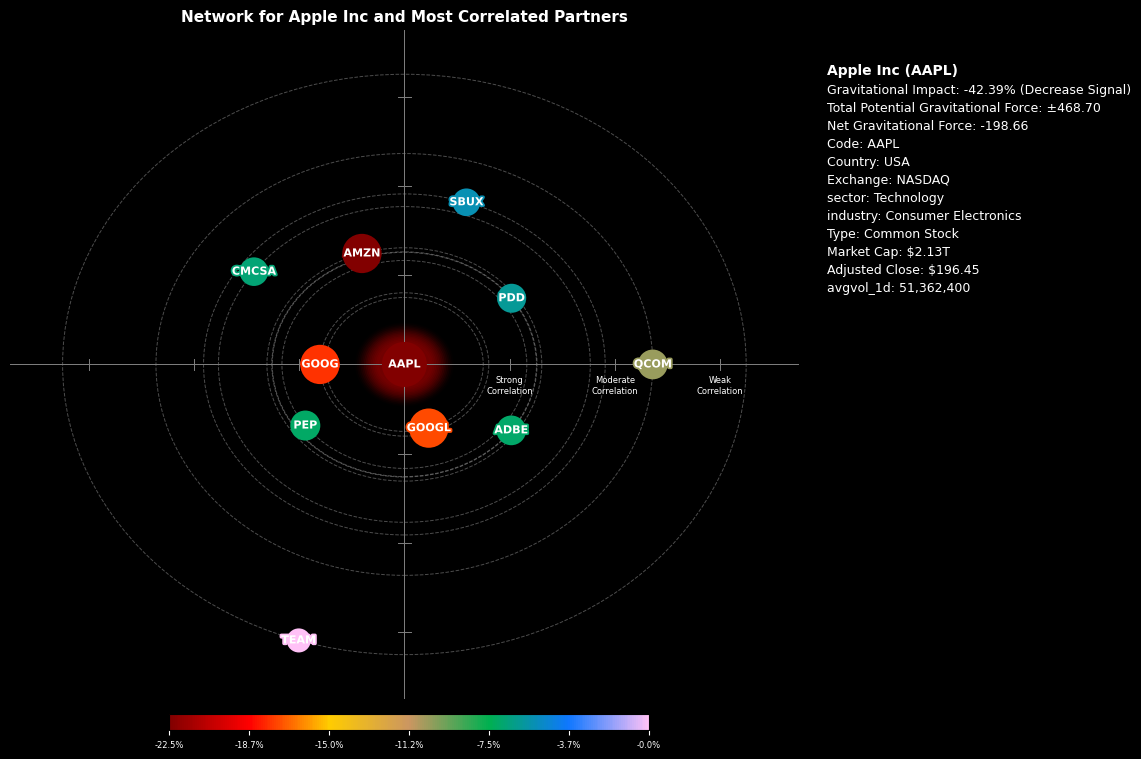

,source,target,Daily Change,six_month_spearman_correlation,three_month_spearman_correlation,unified_correlation,Orbital Radius,Market Cap,Planet Radius,market_cap_influence,gravitational_force,signed_gravitational_force,gravitational_percent
10,AAPL,AMZN,-0.5346,0.708744,0.271163,0.446195,0.222700,2.126178e+12,0.999999,0.999999,44.619441,-44.619441,-22.460189
59,AAPL,GOOG,-0.6159,0.703969,0.119290,0.353161,0.021081,2.126178e+12,0.999999,0.999999,35.316093,-35.316093,-17.777141
60,AAPL,GOOGL,-0.5862,0.698012,0.107048,0.343434,0.000000,2.126188e+12,1.000000,1.000000,34.343374,-34.343374,-17.287501
121,AAPL,QCOM,-2.5079,0.671963,0.620315,0.640974,0.644815,1.698826e+11,0.320207,0.320207,20.524446,-20.524446,-10.331437
115,AAPL,PEP,-1.0960,0.645572,0.269454,0.419901,0.165716,1.794058e+11,0.334880,0.334880,14.061641,-14.061641,-7.078240
1,AAPL,ADBE,-5.3181,0.793721,0.198912,0.436836,0.202416,1.669340e+11,0.315497,0.315497,13.782036,-13.782036,-6.937495
27,AAPL,CMCSA,-0.7372,0.608778,0.479690,0.531325,0.407190,1.307168e+11,0.249706,0.249706,13.267486,-13.267486,-6.678484
114,AAPL,PDD,-2.7555,0.183501,0.607262,0.437758,0.204415,1.427884e+11,0.273468,0.273468,11.971270,-11.971270,-6.026005
125,AAPL,SBUX,-1.1238,0.636437,0.504822,0.557468,0.463846,1.059807e+11,0.193273,0.193273,10.774348,-10.774348,-5.423508
134,AAPL,TEAM,-1.2543,0.853562,0.772406,0.804868,1.000000,5.166643e+10,0.000000,0.000000,0.000000,-0.000000,-0.000000


In [18]:
# --- MODIFIED: Network Diagram Plotting Function ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions
import matplotlib.patheffects as path_effects # Import for text outline

def plot_ticker_network_visual(source_ticker, processed_data_df, gravitational_impact, max_potential_force, net_gravitational_force, screener_data_df):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    Includes a detailed information box for the source ticker.
    All data is sourced from the processed_data_df.
    """
    # Filter for connections related to the source ticker
    ticker_connections = processed_data_df[processed_data_df['source'] == source_ticker].copy()

    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Filter out any potential self-loops that might have slipped through, although they should be handled by process_and_score_stocks
    ticker_connections = ticker_connections[ticker_connections['source'] != ticker_connections['target']].copy()

    # Ensure the edge attributes list matches the columns available in ticker_connections
    # Corrected based on the expected columns from process_and_score_stocks
    edge_attributes = [
        'Orbital Radius',
        'Planet Radius',
        'gravitational_percent', # Use gravitational_percent for coloring
        'Daily Change',
        'Market Cap',
        'six_month_spearman_correlation',
        'three_month_spearman_correlation',
    ]

    # Create the graph
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                edge_attributes)

    # Add the source ticker node explicitly if it's not already added as a target
    if source_ticker not in G.nodes():
        G.add_node(source_ticker)

    # Use subplots to have more control over the layout (graph on left, info on right)
    fig, (ax_main, ax_info) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.patch.set_facecolor('black')
    ax_main.set_facecolor('black')
    ax_info.set_facecolor('black')

    # --- Reticle and Orbits on the main axis ---
    reticle_color = 'gray'
    ax_main.axhline(0, color=reticle_color, linestyle='-', linewidth=0.7)
    ax_main.axvline(0, color=reticle_color, linestyle='-', linewidth=0.7)

    radii = {'Strong': 0.4, 'Moderate': 0.8, 'Weak': 1.2}
    tick_length = 0.025

    for strength, r in radii.items():
        ax_main.plot([-tick_length, tick_length], [r, r], color=reticle_color, linewidth=0.7)
        ax_main.plot([-tick_length, tick_length], [-r, -r], color=reticle_color, linewidth=0.7)
        ax_main.plot([r, r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)
        ax_main.plot([-r, -r], [-tick_length, tick_length], color=reticle_color, linewidth=0.7)

    # Add labels for the reticle just below the tick marks on the positive x-axis
    label_offset_y = 0.05
    ax_main.text(radii['Strong'], -label_offset_y, 'Strong\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Moderate'], -label_offset_y, 'Moderate\nCorrelation', color='white', ha='center', va='top', fontsize=6)
    ax_main.text(radii['Weak'], -label_offset_y, 'Weak\nCorrelation', color='white', ha='center', va='top', fontsize=6)


    pos = {}
    pos[source_ticker] = (0, 0)

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)

        # Calculate min and max orbital radius from the filtered connections
        min_orbital_radius = actual_target_connections['Orbital Radius'].min()
        max_orbital_radius = actual_target_connections['Orbital Radius'].max()
        # Handle the case where all orbital radii are the same to avoid division by zero
        radius_range = max_orbital_radius - min_orbital_radius if max_orbital_radius != min_orbital_radius else 1.0


        for i, target_node_name in enumerate(list(actual_target_connections['target'])):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']

            # Use the already scaled orbital radius from processed_data_df
            scaled_orbital_radius = orbital_radius # This is now the value between 0 and 1

            min_distance = 0.3
            current_orbital_radius = scaled_orbital_radius + min_distance


            orbit_patch = plt.Circle((0, 0), current_orbital_radius, fill=False, linestyle='--', edgecolor=reticle_color, linewidth=0.7, alpha=0.6)
            ax_main.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    # --- Node Sizing and Coloring ---
    min_planet_size, max_planet_size = 0.05, 1.5
    epsilon = 1e-9

    # Get min/max market caps from the processed_data_df for consistent scaling within this plot
    # Include the source ticker's market cap for scaling if it's not already a target
    all_market_caps = processed_data_df['Market Cap'].tolist()
    source_info_row = processed_data_df[processed_data_df['source'] == source_ticker]
    source_market_cap_for_scaling = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else None

    if source_market_cap_for_scaling is not None:
         all_market_caps.append(source_market_cap_for_scaling)

    global_min_market_cap = min(all_market_caps) if all_market_caps else epsilon
    global_max_market_cap = max(all_market_caps) if all_market_caps else epsilon

    log_min_mc, log_max_mc = np.log(max(global_min_market_cap, epsilon)), np.log(max(global_max_market_cap, epsilon))


    # Calculate source node size using its market cap from processed_data_df
    source_market_cap = source_info_row['Market Cap'].iloc[0] if not source_info_row.empty else epsilon
    source_market_cap = max(source_market_cap, epsilon)
    log_source_mc = np.log(source_market_cap)
    normalized_source_mc = 0.0 if log_max_mc == log_min_mc else (log_source_mc - log_min_mc) / (log_max_mc - log_min_mc)
    source_planet_radius = min_planet_size + (normalized_source_mc * (max_planet_size - min_planet_size))
    source_node_size = 300 + (source_planet_radius * 500)

    node_sizes_dict = {node: 300 + (ticker_connections[ticker_connections['target'] == node]['Planet Radius'].values[0] * 500) if node != source_ticker else source_node_size for node in G.nodes()}
    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Use gravitational_percent from processed_data_df for coloring ---
    colors = ['#820000', '#FF0000', '#FFCC00', '#CB9661', '#00B050', '#0E77FF', '#FFC1F6']
    cmap = mcolors.LinearSegmentedColormap.from_list('weight_cmap', colors)

    # Determine min/max gravitational_percent for normalization to the colormap range (-1 to 1)
    all_gravitational_percent = processed_data_df['gravitational_percent'].values
    min_gravitational_percent, max_gravitational_percent = np.min(all_gravitational_percent), np.max(all_gravitational_percent)
    norm_gravitational_percent = mcolors.Normalize(vmin=min_gravitational_percent, vmax=max_gravitational_percent)

    node_colors_list = []
    # Ensure gravitional_impact is a scalar float
    gravitational_impact_scalar = float(gravitational_impact)
    for node in G.nodes():
        if node == source_ticker:
             # Color the source node based on the overall gravitional_impact
            # Handle the case where gravitional_impact is 0 to avoid zero range in normalization
            if gravitational_impact_scalar == 0:
                norm_source = mcolors.Normalize(vmin=np.min(processed_data_df['gravitational_percent'].values), vmax=np.max(processed_data_df['gravitational_percent'].values))
            else:
                # Normalize based on the min/max gravitational_impact
                norm_source = mcolors.Normalize(vmin=min_gravitational_percent, vmax=max_gravitational_percent)

            source_node_color = cmap(norm_source(gravitational_impact_scalar))
            node_colors_list.append(source_node_color)
        else:
            # Color target nodes based on their gravitational_percent
            gravitational_percent_value = processed_data_df[(processed_data_df['source'] == source_ticker) & (processed_data_df['target'] == node)]['gravitational_percent'].values
            if gravitational_percent_value.size > 0:
                node_colors_list.append(cmap(norm_gravitational_percent(gravitational_percent_value[0])))
            else:
                # Default color if weight is not found (shouldn't happen with correct filtering)
                node_colors_list.append('gray')


    # --- Draw Aura and Nodes on the main axis ---
    aura_base_radius = np.sqrt(source_node_size / 300) * 0.05
    # Draw auras only for the source node
    for i in range(1, 15):
        aura = plt.Circle(pos[source_ticker], aura_base_radius * (1 + i * 0.07), color=source_node_color, alpha=0.3 * (1 - (i / 15)))
        ax_main.add_patch(aura)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=1.0, linewidths=0, ax=ax_main)

    # --- Draw Labels on the main axis ---
    node_color_map = dict(zip(G.nodes(), node_colors_list))
    for node in G.nodes():
        if node in pos:
            node_x, node_y = pos[node]
            node_color = node_color_map[node]
            txt = ax_main.text(node_x, node_y, str(node), color='white', fontweight='bold', fontsize=8, ha='center', va='center')
            txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color), path_effects.Normal()])

    # Fetch company name for the title from screener_data_df
    source_screener_info_for_title = screener_data_df[screener_data_df['code'] == source_ticker]
    company_name = source_screener_info_for_title['name'].iloc[0] if not source_screener_info_for_title.empty and 'name' in source_screener_info_for_title.columns else source_ticker
    ax_main.set_title(f'Network for {company_name} and Most Correlated Partners', color='white', fontsize=11, fontweight='bold')
    ax_main.axis('off')
    ax_main.set_xlim(-1.5, 1.5)
    ax_main.set_ylim(-1.5, 1.5)

    # --- Create Information Box on the right axis ---
    # Get source ticker info from screener_data_df
    source_screener_info = screener_data_df[screener_data_df['code'] == source_ticker].iloc[0] if not screener_data_df[screener_data_df['code'] == source_ticker].empty else None
    source_processed_info = processed_data_df[processed_data_df['source'] == source_ticker].iloc[0] if not processed_data_df[processed_data_df['source'] == source_ticker].empty else None


    if source_screener_info is None or source_processed_info is None:
         print(f"Warning: Source ticker {source_ticker} not found in necessary dataframes for info box.")
         info_text = "Information not available."
         company_name_info = source_ticker # Use ticker as name if not found
    else:
        # Determine gravitional force text
        if gravitational_impact >= 90:
            score_meaning = "Strong Increase Signal"
        elif gravitational_impact > 70:
            score_meaning = "Increase Signal"
        elif gravitational_impact > 40:
            score_meaning = "Weak Increase Signal"
        elif gravitational_impact <= -90:
            score_meaning = "Strong Decrease Signal"
        elif gravitational_impact < -70:
            score_meaning = "Decrease Signal"
        elif gravitational_impact < -40:
            score_meaning = "Decrease Signal"
        else:
            score_meaning = "Neutral/Mixed Signals"

        # Format Market Cap for readability (using Market Cap from processed_data_df)
        market_cap = source_processed_info['Market Cap']
        if market_cap > 1_000_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000_000:.2f}T"
        elif market_cap > 1_000_000_000:
            market_cap_str = f"${market_cap/1_000_000_000:.2f}B"
        else:
            market_cap_str = f"${market_cap/1_000_000:.2f}M"

        # Assuming 'Daily Change' is in percentage in processed_data_df
        daily_change_percent = source_processed_info['Daily Change']

        # Format the information string, using screener_data_df for specific fields
        info_text = (
            # Divide prediction_score_scalar by 100 for display as percentage
            f"Gravitational Impact: {gravitational_impact:.2f}% ({score_meaning})\n"
            f"Total Potential Gravitational Force: ±{max_potential_force:.2f}\n"
            f"Net Gravitational Force: {net_gravitational_force:.2f}\n"
            f"Code: {source_ticker}\n"
            # Get Country, Exchange, Sector, Industry, Type from screener_data_df
            f"Country: {source_screener_info.get('Country', 'N/A')}\n"
            f"Exchange: {source_screener_info.get('Exchange', 'N/A')}\n"
            f"sector: {source_screener_info.get('sector', 'N/A')}\n"
            f"industry: {source_screener_info.get('industry', 'N/A')}\n"
            f"Type: {source_screener_info.get('Type', 'N/A')}\n"
            f"Market Cap: {market_cap_str}\n"
            # Assuming adjusted_close and avgvol_1d are in screener_data_df
            f"Adjusted Close: ${source_screener_info.get('adjusted_close', 0):.2f}\n"
            f"avgvol_1d: {int(source_screener_info.get('avgvol_1d', 0)):,}"
        )
        # Corrected access to the 'name' attribute from the Series
        company_name_info = source_screener_info['name'] if 'name' in source_screener_info and not source_screener_info.empty else source_ticker


    # Add the text to the info axis, adjusting the y position to reduce the gap
    ax_info.text(0.05, 0.95, f"{company_name_info} ({source_ticker})", transform=ax_info.transAxes, fontsize=10, fontweight='bold', color='white', ha='left', va='top')
    ax_info.text(0.05, 0.92, info_text, transform=ax_info.transAxes, fontsize=9, color='white', ha='left', va='top', linespacing=1.5)
    ax_info.axis('off')

    # --- ADDED BACK: Add Colorbar Legend at the bottom of the main graph axis ---
    cbar_ax = fig.add_axes([0.145, 0.08, 0.4, 0.02]) # Adjusted position [left, bottom, width, height]
    # Use the same colormap and normalization as used for the target nod
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_gravitational_percent)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    # Set the ticks and labels for the colorbar based on the range of normalized weights
    cbar.set_ticks(np.linspace(min_gravitational_percent, max_gravitational_percent, 7))
    # Generate labels that represent the range of weights, formatted as percentages
    labels = [f'{val:.1f}%' for val in np.linspace(min_gravitational_percent, max_gravitational_percent, 7)]
    cbar.set_ticklabels(labels)

    # Style the colorbar labels
    cbar.ax.tick_params(colors='white', labelsize=6)


    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for colorbar
    plt.show()

## ---------- MODIFIED: Run App ---------------
min_nodes = 10
max_nodes = 20
threshold_percent = 0.9

# User input Ticker
source_ticker = 'AAPL' # Changed back to MSFT for initial test

# Process the data for the network diagram
processed_data_df, net_gravitational_force, max_potential_force, gravitational_impact = process_and_score_stocks(
    six_month_spearman_lagged_correlations,
    three_month_spearman_lagged_correlations,
    screener_data_df,
    source_ticker,
    min_nodes,
    max_nodes,
    threshold_percent,
    )

# Pass the score and the prediction_score_df to the plotting function
plot_ticker_network_visual(source_ticker, processed_data_df, gravitational_impact, max_potential_force, net_gravitational_force, screener_data_df)

processed_data_df

##List of Top Predictions

In [16]:
import pandas as pd
top_gravitational_impacts = []

# Ensure unified_correlation_df is created from six_month_spearman_lagged_correlations
# assuming unified_correlation_df is meant to represent the base correlations
# based on the usage in the provided code for process_and_score_stocks.
# If unified_correlation_df should be different, please adjust this.
unified_correlation_df = six_month_spearman_lagged_correlations.copy()


# Iterate through each ticker in the unified_correlation_df
for ticker in tqdm(unified_correlation_df.index, desc="Processing tickers for gravitational impact"):
    try:
        # Run each ticker through the process_and_score_stocks function
        # Note: The function previously returned processed_data_df and prediction_score.
        # It now returns processed_data_df, net_gravitational_force, max_potential_force, gravitational_impact
        # We need to unpack the new return values.
        processed_df, net_force, max_potential, gravitational_impact_score = process_and_score_stocks(
            six_month_spearman_lagged_correlations, # Pass the 6-month correlation
            three_month_spearman_lagged_correlations, # Pass the 3-month correlation
            screener_data_df,
            ticker, # Use the current ticker as source_ticker
            min_nodes,
            max_nodes,
            threshold_percent,
        )

        # Append the results to the list
        top_gravitational_impacts.append({
            'ticker': ticker,
            'net_gravitational_force': net_force,
            'max_potential_force': max_potential,
            'gravitational_impact': gravitational_impact_score
        })
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")

# Create a DataFrame from the results
gravitational_impact_df = pd.DataFrame(top_gravitational_impacts)

# Sort by the absolute value of gravitational_impact in descending order
gravitational_impact_df = gravitational_impact_df.sort_values(by='gravitational_impact', key=abs, ascending=False).reset_index(drop=True)

# Display the table
print("Top Gravitational Impact Tickers:")
print(gravitational_impact_df[['ticker', 'net_gravitational_force', 'max_potential_force', 'gravitational_impact']].to_string(index=False, formatters={'net_gravitational_force': '{:.2f}'.format, 'max_potential_force': '{:.2f}'.format, 'gravitational_impact': '{:.2f}'.format}))

Processing tickers for gravitational impact:   0%|          | 0/262 [00:00<?, ?it/s]

Top Gravitational Impact Tickers:
ticker net_gravitational_force max_potential_force gravitational_impact
  LRCX                 -632.78              823.98               -76.79
    MU                 -601.45              806.78               -74.55
  TSLA                 -579.34              801.25               -72.30
    ZS                 -495.86              697.66               -71.08
   GEN                 -582.88              823.98               -70.74
  KLAC                 -582.02              823.98               -70.63
  EBAY                 -499.49              713.68               -69.99
  LECO                 -556.53              805.74               -69.07
  MNDY                 -520.68              754.16               -69.04
   WWD                 -568.72              823.98               -69.02
   CSX                 -570.63              830.99               -68.67
  FFIV                 -564.79              823.98               -68.54
   ARM                 -564.35

#Dash App with Solar System

##Setup

In [2]:
# Dash App Setup

#Terminal Command
#ngrok config add-authtoken 2yPWVwCXJDsY9JkhLhnrn549R5E_5b2uFuh7R4ER3fLJWLU59

# Install necessary libraries (run this cell first)
!pip install -q dash dash-bootstrap-components plotly pyngrok

# --- Import necessary libraries ---
from dash import Dash, html, dcc, Input, Output # We need dcc for interactive components and Input/Output for callbacks
import os
from pyngrok import ngrok
from google.colab import userdata

# # --- Configure Ngrok for public access ---
# NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
# os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN

# --- Configure Ngrok for public access ---
# This part remains the same to create a public URL for your app
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    # Use pyngrok to set the auth token programmatically
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
except userdata.SecretNotFoundError:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
    # You might want to handle this case, e.g., by exiting or using a default token if applicable
    exit()


# Define the port your Dash app will run on.
DASH_PORT = 8051

In [62]:
# Kills all ngrok processes that pyngrok started
print("Attempting to kill all active ngrok tunnels...")
ngrok.kill()
print("All ngrok tunnels should now be terminated.")

# Add a short delay to ensure the process is killed
import time
time.sleep(5)

Attempting to kill all active ngrok tunnels...
All ngrok tunnels should now be terminated.


In [3]:
# Create a public ngrok tunnel to the specified port.
print("Establishing Ngrok tunnel...")
public_url = ngrok.connect(DASH_PORT)
print(f"🚀 Your Dash app will be accessible at: {public_url}")

Establishing Ngrok tunnel...
🚀 Your Dash app will be accessible at: NgrokTunnel: "https://25eb-35-231-189-135.ngrok-free.app" -> "http://localhost:8051"


## Dash App

In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

#Start Dummy Data---------------------------------------------------------------------------------------------------------
# Static dummy data for source_ticker 'AAPL'
source_ticker = 'AAPL'

# Static dummy data for processed_data_df (based on previous output for AAPL)
data = {
    'source': ['AAPL'] * 10,
    'target': ['AMZN', 'GOOG', 'GOOGL', 'QCOM', 'CMCSA', 'SBUX', 'TEAM', 'ADBE', 'PEP', 'PDD'],
    'Daily Change': [-0.53, -0.62, -0.59, -2.51, -0.74, -1.12, -1.25, -5.32, -1.10, -2.76],
    'six_month_spearman_correlation': [0.7087, 0.7040, 0.6980, 0.6720, 0.6088, 0.6364, 0.8536, 0.7937, 0.6456, 0.1835],
    'three_month_spearman_correlation': [0.2712, 0.1193, 0.1070, 0.6203, 0.4797, 0.5048, 0.7724, 0.1989, 0.2695, 0.6073],
    'unified_correlation': [0.4462, 0.3532, 0.3434, 0.6410, 0.5313, 0.5575, 0.8049, 0.4368, 0.4199, 0.4378],
    'Orbital Radius': [0.7, 0.8, 0.9, 0.6, 1.0, 1.1, 0.65, 1.2, 0.67, 1.4], # Original data for scaling
    'Market Cap': [2.25e+12, 2.13e+12, 2.13e+12, 1.70e+11, 1.31e+11, 1.06e+11, 5.17e+10, 1.67e+11, 1.79e+11, 1.43e+11],
    'Planet Radius': [1.0000, 0.9848, 0.9848, 0.3153, 0.2459, 0.1903, 0.0000, 0.3107, 0.3298, 0.2693],
    'market_cap_influence': [0.9260, 0.9162, 0.9162, 0.4817, 0.4366, 0.4006, 0.2770, 0.4787, 0.4911, 0.4518],
    'gravitational_force': [41.3, 32.4, 31.5, 30.9, 23.2, 22.3, 22.3, 20.9, 20.6, 19.8],
    'signed_gravitational_force': [-41.3, -32.4, -31.5, -30.9, -23.2, -22.3, -22.3, -20.9, -20.6, -19.8],
    'gravitational_percent': [-15.58, -12.20, -11.87, -11.64, -8.75, -8.42, -8.41, -7.89, -7.78, -7.46]
}
processed_data_df = pd.DataFrame(data)

# Add the separate metrics to the DataFrame for hover info
processed_data_df['gravitational_impact'] = -59.46
processed_data_df['net_gravitational_force'] = -477.29
processed_data_df['max_potential_force'] = 802.70

# Static dummy data for screener_data_df
screener_data_dict = {
    'code': ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'QCOM', 'CMCSA', 'SBUX', 'TEAM', 'ADBE', 'PEP', 'PDD', 'MSFT', 'TSLA'],
    'name': ['Apple Inc', 'Amazon.com Inc', 'Alphabet Inc Class C', 'Alphabet Inc Class A', 'QUALCOMM Inc.', 'Comcast Corporation', 'Starbucks Corporation', 'Atlassian Corporation Plc', 'Adobe Inc.', 'PepsiCo Inc.', 'PDD Holdings Inc.', 'Microsoft Corporation', 'Tesla, Inc.'],
    'sector': ['Technology', 'Consumer Cyclical', 'Communication Services', 'Communication Services', 'Technology', 'Communication Services', 'Consumer Cyclical', 'Technology', 'Technology', 'Consumer Defensive', 'Consumer Cyclical', 'Technology', 'Consumer Cyclical'],
    'industry': ['Consumer Electronics', 'Internet Retail', 'Internet Content & Information', 'Internet Content & Information', 'Semiconductors', 'Cable & Satellite', 'Restaurants', 'Software - Infrastructure', 'Software - Application', 'Beverages - Non-Alcoholic', 'Internet Retail', 'Software - Infrastructure', 'Auto Manufacturers'],
}
screener_data_df = pd.DataFrame(screener_data_dict)

#End Dummy Data------------------------------------------------------------------------------------------------------------------------

def plot_ticker_network_visual(source_ticker, processed_data_df, screener_data_df):
    """
    Plots a 2D solar system style interactive network graph with an isometric view and scaled orbits.
    """
    ticker_connections = processed_data_df[processed_data_df['source'] == source_ticker].copy()
    if ticker_connections.empty:
        return go.Figure()

    # --- Node Positioning with Scaled Orbital Radius ---
    pos = {source_ticker: (0, 0, 0)} # Sun at the center
    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker].copy()
    num_connections = len(actual_target_connections)

    radii_for_rings = []
    fig = go.Figure()

    if num_connections > 0:
        # --- Corrected Orbital Radius Logic ---
        original_radii = actual_target_connections['Orbital Radius']
        min_rad = original_radii.min()
        max_rad = original_radii.max()
        rad_range = max_rad - min_rad if max_rad > min_rad else 1.0

        # Define the visual range for orbits
        min_visual_radius = 0.6
        max_visual_radius = 2.0
        visual_range = max_visual_radius - min_visual_radius

        thetas = np.linspace(0, 2 * np.pi, num_connections, endpoint=False) # Distribute evenly

        # Calculate planet positions with scaled radius
        for i, (index, row) in enumerate(actual_target_connections.iterrows()):
            target_node_name = row['target']
            original_radius = row['Orbital Radius']

            # Scale the radius proportionally to the new visual range
            # (original - min) / range gives a 0-1 value, then scale to visual range
            scaled_radius = ((original_radius - min_rad) / rad_range) * visual_range + min_visual_radius
            radii_for_rings.append(scaled_radius)

            theta = thetas[i]
            x = scaled_radius * np.cos(theta)
            y = scaled_radius * np.sin(theta)
            z = 0
            pos[target_node_name] = (x, y, z)

    # --- Add Orbital Rings ---
    unique_radii = sorted(list(set(radii_for_rings)))
    for r in unique_radii:
        theta_ring = np.linspace(0, 2 * np.pi, 100)
        x_ring = r * np.cos(theta_ring)
        y_ring = r * np.sin(theta_ring)
        z_ring = np.zeros(100)
        fig.add_trace(go.Scatter3d(
            x=x_ring, y=y_ring, z=z_ring,
            mode='lines',
            line=dict(color='rgba(100, 100, 100, 0.5)', width=1, dash='dot'),
            hoverinfo='none'
        ))

    # --- Add Nodes ---
    node_x, node_y, node_z = [], [], []
    hover_texts, node_sizes, node_colors, node_labels = [], [], [], []

    for node_name, coords in pos.items():
        node_x.append(coords[0])
        node_y.append(coords[1])
        node_z.append(coords[2])

        is_source = (node_name == source_ticker)
        screener_info = screener_data_df[screener_data_df['code'] == node_name]
        processed_info = ticker_connections.iloc[:1] if is_source else ticker_connections[ticker_connections['target'] == node_name]

        if not screener_info.empty and not processed_info.empty:
            screener_info = screener_info.iloc[0]
            processed_info = processed_info.iloc[0]

            market_cap = processed_info['Market Cap']
            if market_cap > 1e12: market_cap_str = f"${market_cap/1e12:.2f}T"
            elif market_cap > 1e9: market_cap_str = f"${market_cap/1e9:.2f}B"
            else: market_cap_str = f"${market_cap/1e6:.2f}M"

            if is_source:
                text = (
                    f"<b>{screener_info.get('name', node_name)} ({node_name})</b><br>"
                    f"Gravitational Impact: {processed_info['gravitational_impact']:.2f}%<br>"
                    f"Net Gravitational Force: {processed_info['net_gravitational_force']:.2f}<br>"
                    f"Market Cap: {market_cap_str}"
                )
                node_colors.append(processed_info['gravitational_impact'])
                node_sizes.append(60) # Make sun larger
            else:
                text = (
                    f"<b>{screener_info.get('name', node_name)} ({node_name})</b><br>"
                    f"Unified Correlation: {processed_info['unified_correlation']:.2f}<br>"
                    f"Gravitational Percent: {processed_info['gravitational_percent']:.2f}%<br>"
                    f"Market Cap: {market_cap_str}"
                )
                node_colors.append(processed_info['gravitational_percent'])
                node_sizes.append(processed_info['Planet Radius'] * 30 + 10)

            hover_texts.append(text)
            node_labels.append(node_name)
        else:
            hover_texts.append(f"<b>{node_name}</b><br>Info unavailable.")
            node_sizes.append(15)
            node_colors.append(0)
            node_labels.append(node_name)

    # --- Configure Node Trace ---
    vmin, vmax = (np.min(node_colors), np.max(node_colors)) if node_colors else (0, 0)
    if vmin == vmax: vmin, vmax = vmin - 1, vmax + 1

    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers+text',
        hoverinfo='text', text=node_labels, textposition='bottom center',
        textfont=dict(color='white', size=10),
        marker=dict(
            showscale=True, colorscale='RdYlBu', color=node_colors,
            size=node_sizes, opacity=0.9,
            colorbar=dict(thickness=15, title='Gravitational Metric', x=0.85, y=0.8, len=0.7),
            cmin=vmin, cmax=vmax,
            symbol='circle'
        ),
        hovertext=hover_texts,
    ))

    # --- Configure Layout ---
    company_name_series = screener_data_df[screener_data_df['code'] == source_ticker]['name']
    company_name = company_name_series.iloc[0] if not company_name_series.empty else source_ticker
    fig.update_layout(
        title=f'Financial Solar System for {company_name} ({source_ticker})',
        title_x=0.5,
        scene=dict(
            xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False),
            # Set camera for a zoomed-in isometric view
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.2, y=1.2, z=1.2)
            ),
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        showlegend=False,
        paper_bgcolor='black',
        plot_bgcolor='black',
        font_color='white'
    )
    return fig


# --- Initialize the Dash application ---
app = Dash(__name__)

# --- Data for Controls ---
ticker_options = [{'label': row['name'] + f" ({row['code']})", 'value': row['code']} for index, row in screener_data_df.iterrows()]
default_ticker = 'AAPL' if 'AAPL' in screener_data_df['code'].unique() else screener_data_df['code'].iloc[0]

# --- Define the app layout ---
app.layout = html.Div(style={'backgroundColor': 'black', 'color': 'white'}, children=[
    html.H1("Financial Planetarium", style={'textAlign': 'center', 'color': '#4A90E2', 'paddingTop': '20px'}),

    html.Div([
        html.Label("Select Ticker:", style={'marginRight': '10px'}),
        dcc.Dropdown(
            id='ticker-dropdown',
            options=ticker_options,
            value=default_ticker,
            style={'width': '300px', 'display': 'inline-block', 'color': '#333'}
        ),
    ], style={'textAlign': 'center', 'padding': '20px'}),

    dcc.Graph(
        id='network-graph',
        figure={}
    ),
])

# --- Define the Callback ---
@app.callback(
    Output('network-graph', 'figure'),
    Input('ticker-dropdown', 'value')
)
def update_network_graph(selected_ticker):
    if not selected_ticker:
        return go.Figure().update_layout(
            title="Please select a ticker.", title_x=0.5,
            paper_bgcolor='black', font_color='white'
        )

    fig = plot_ticker_network_visual(selected_ticker, processed_data_df, screener_data_df)
    return fig

# --- Run the Dash server ---
if __name__ == '__main__':
    app.run(debug=True, port=8051)


<IPython.core.display.Javascript object>